# Vital signs

This example shows how to use Temporian on one of the PhysioNet datasets using [wfdb](https://wfdb.readthedocs.io/en/latest/). We will load the EKG and respiratory records of four patients from the [Apnea-ECG Database](https://www.physionet.org/content/apnea-ecg/1.0.0/), and extract various features, including the detection of the heart beats and the heart beat variability.

## Install the dependencies

In [1]:
pip install wfdb -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import temporian as tp

import os
import wfdb
import pandas as pd
import numpy as np

## Download patient data

In [3]:
patients = ["a01", "a02", "a03"]

tmp_directory = "tmp_vital_signs"
if not os.path.isdir(tmp_directory):
    # Note: The ECG and Respiratory signals are recorded by different devices and with different sampling rates.
    wfdb.dl_database(
        "apnea-ecg",
        dl_dir=tmp_directory,
        records=[p for p in patients] + [p + "r" for p in patients],
    )

## Convert patient data to PhysioNet to Temporian format

In [4]:
def load_patient(patient: list[str]) -> tuple:
    """Returns the ECG and Respiratory signals"""
    signals_ecg, fields_ecg = wfdb.rdsamp(f"tmp/{patient}")
    signals_resp, fields_resp = wfdb.rdsamp(f"tmp/{patient}r")

    df_ecg = pd.DataFrame(signals_ecg, columns=fields_ecg["sig_name"])
    df_resp = pd.DataFrame(signals_resp, columns=fields_resp["sig_name"])

    df_ecg["timestamp"] = np.arange(fields_ecg["sig_len"]) / fields_ecg["fs"]
    df_resp["timestamp"] = np.arange(fields_resp["sig_len"]) / fields_resp["fs"]

    return df_ecg, df_resp


def load_all_patients(patients: list[str]) -> tuple[tp.EventData, tp.EventData]:
    data = [load_patient(p) for p in patients]

    merged_df_ecg = pd.concat(
        [d[0].assign(patient=p) for d, p in zip(data, patients)]
    )
    merged_df_resp = pd.concat(
        [d[1].assign(patient=p) for d, p in zip(data, patients)]
    )

    return (
        tp.EventData.from_dataframe(merged_df_ecg, index_names=["patient"]),
        tp.EventData.from_dataframe(merged_df_resp, index_names=["patient"]),
    )


ecg_data, resp_data = load_all_patients(patients)

## Data processing and visualization

Let's plot the full data data (can take a few seconds).

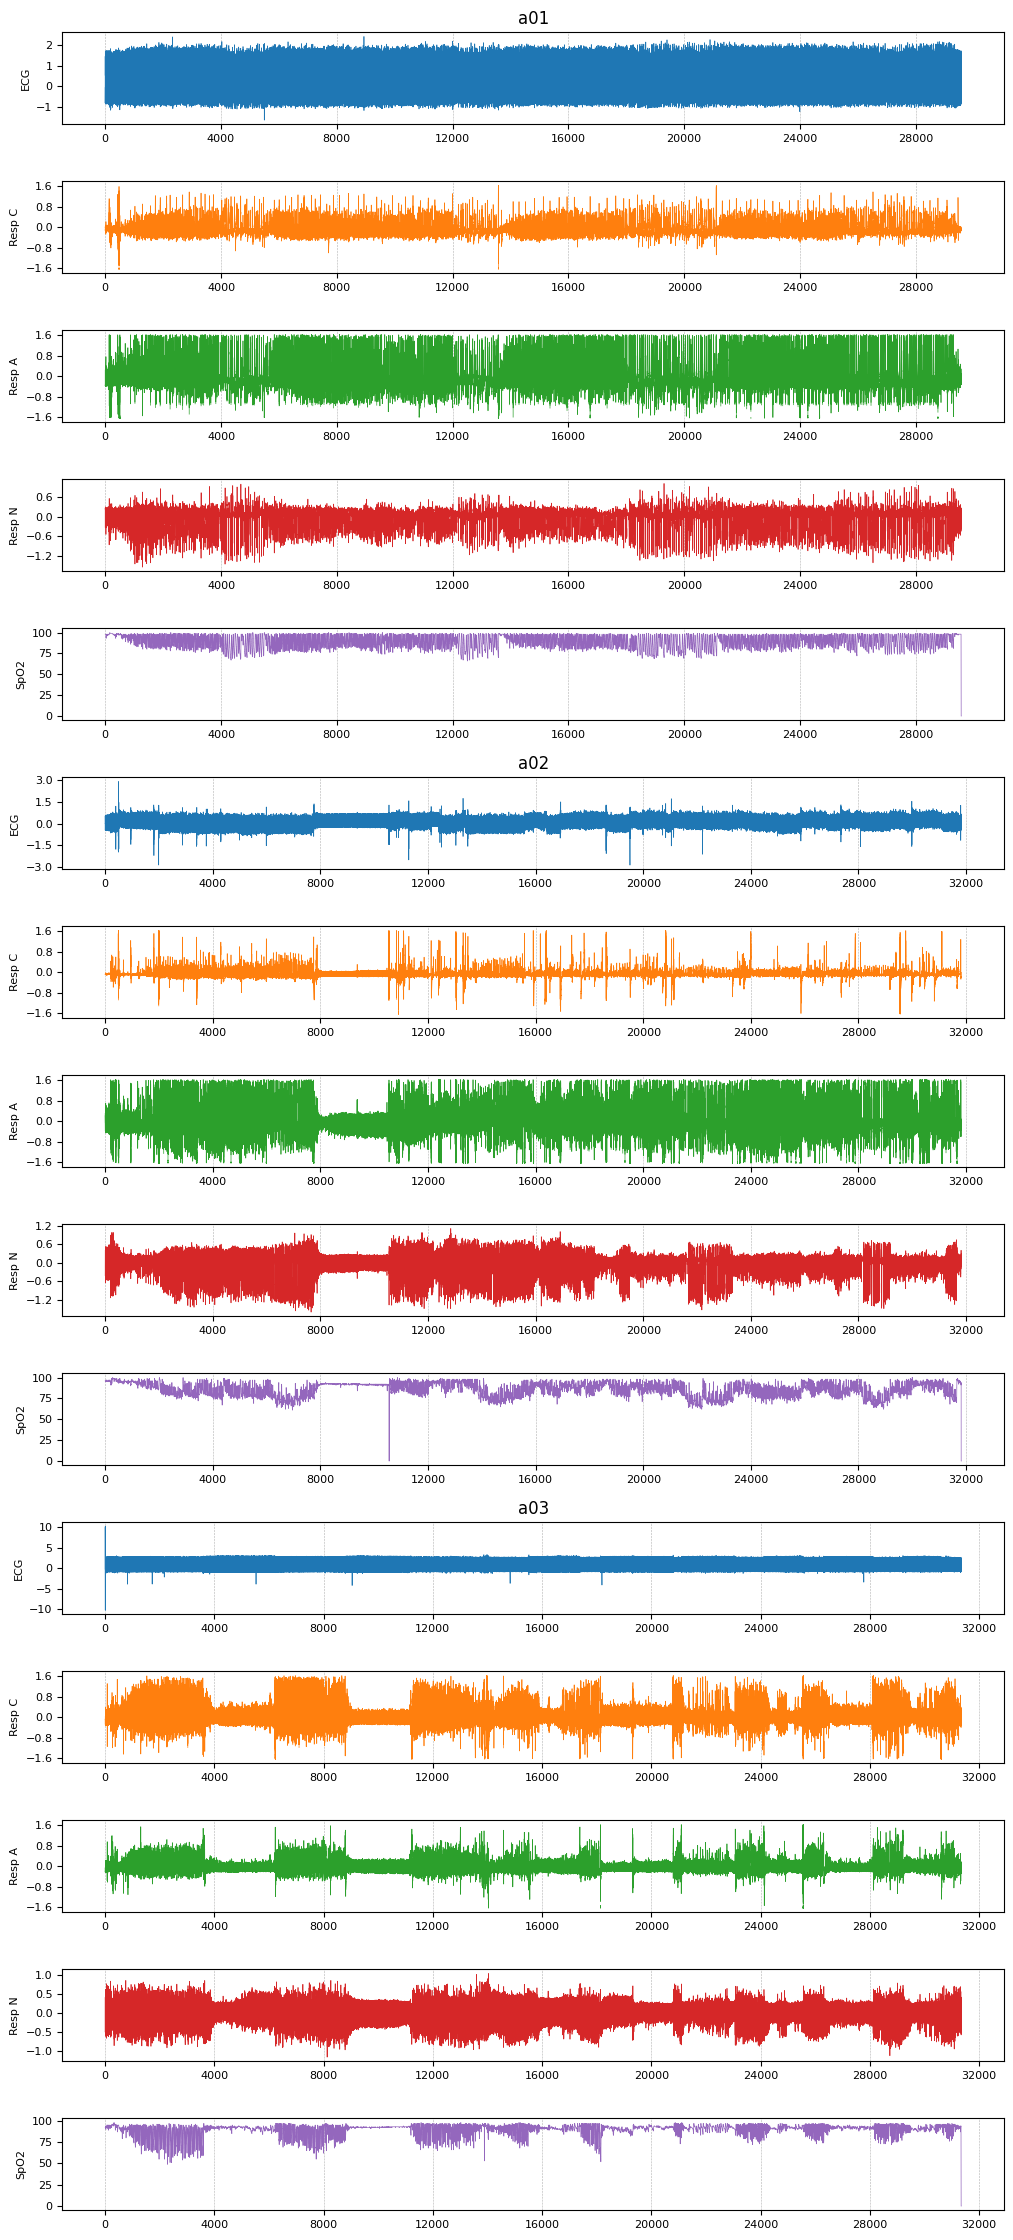

In [5]:
tp.plot([ecg_data, resp_data])

This is too much data to visualize. Instead, let's print the first 15 seconds of the first patient.

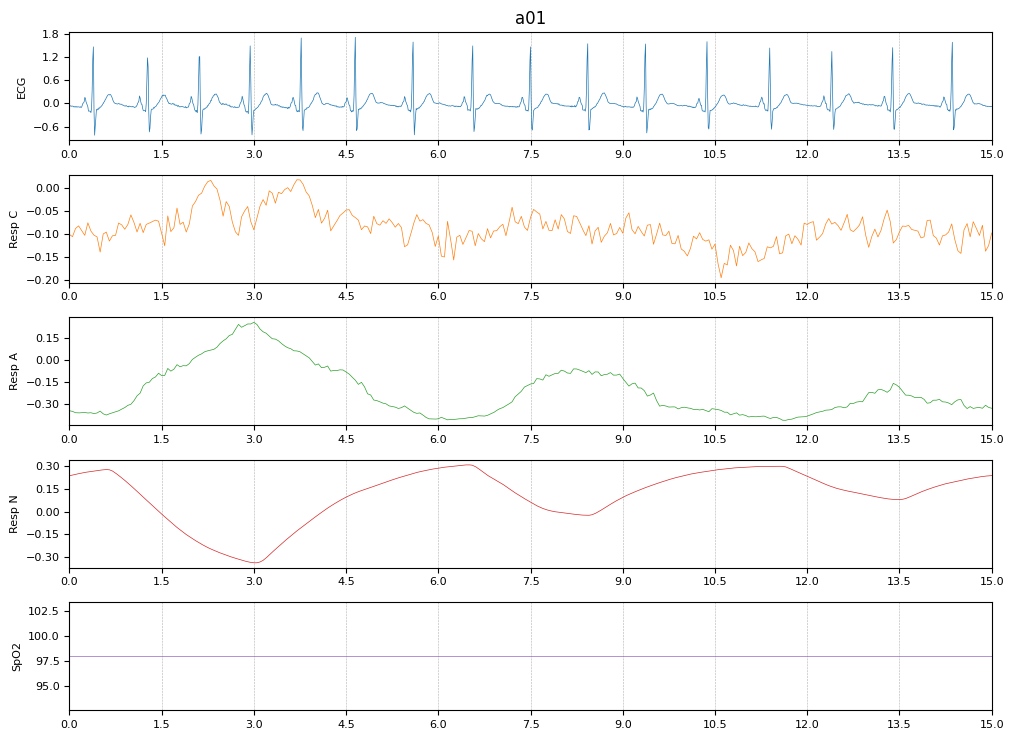

In [6]:
plot_args = {"min_time": 0, "max_time": 15, "indexes": "a01"}
tp.plot([ecg_data, resp_data], **plot_args)

Using Temporian, let's detect the heart beats from the ecg.

A heart beat is detected when two criteria are true:
- Criterion #1: The instantanious ecg is in the top 70% of the moving range computed over the last 3 seconds.
- Criterion #2: There is at least 60/200=300ms (i.e. 200bpm) since the last criteria 1 candidate.


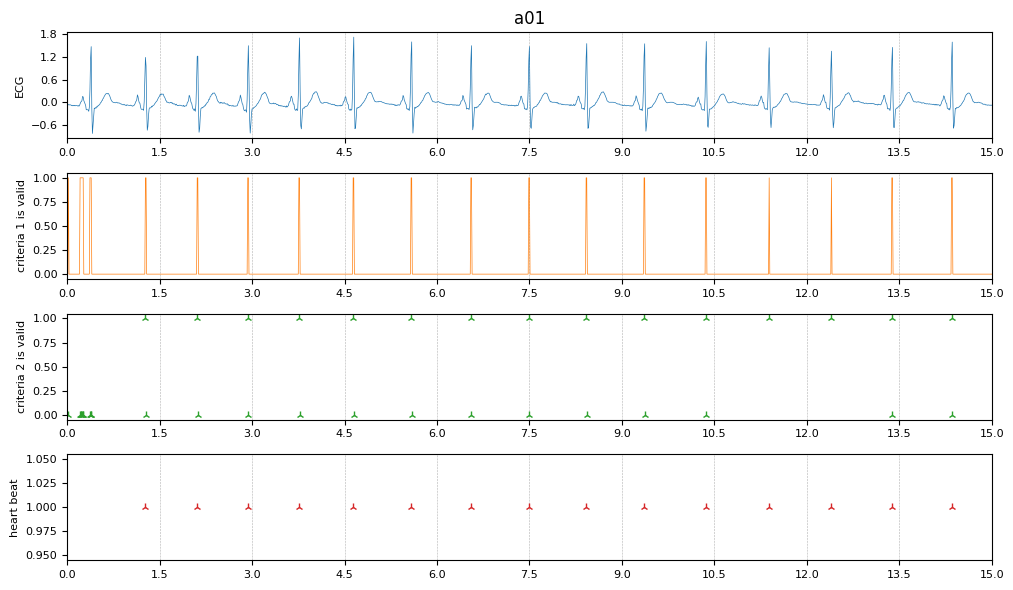

In [7]:
ecg_node = ecg_data.schema()

ecg = ecg_node["ECG"]

# === Begin of heart beat detection code ===
# Compute the moving min, max and range of the ECG
mmin = tp.moving_min(ecg, 3.0)
mmax = tp.moving_max(ecg, 3.0)
mrange = mmax - mmin

# TODO: Replace with "ecg > mmin + ecg_mrange * 0.7"
criteria_1_is_valid = ecg - (mmin + mrange * 0.7) > 0.0
# TODO: Make "filter" able to take an "events" without features as input (or a single argument)?
criteria_1_candidates = tp.filter(criteria_1_is_valid, criteria_1_is_valid)
criteria_2_is_valid = tp.since_last(criteria_1_candidates) > 60.0 / 200

heart_beats = tp.rename(
    tp.filter(criteria_2_is_valid, criteria_2_is_valid), "heart beat"
)
# === End of heart beat detection code ===

to_plot = [
    ecg,
    tp.rename(criteria_1_is_valid, "criteria 1 is valid"),
    tp.rename(criteria_2_is_valid, "criteria 2 is valid"),
    heart_beats,
    # Add more intermediate results here to better understand the detection of heart beats.
]

tp.plot(tp.evaluate(to_plot, {ecg_node: ecg_data}), **plot_args)

From the heartbeats, let's compute the *heart rate* and *heart rate variability*.

The heart rate is the average heart beat frequency over the last 10 expressed in beats-per-minutes (bpm). It can be computed by counting the number of beats in 60 seconds.

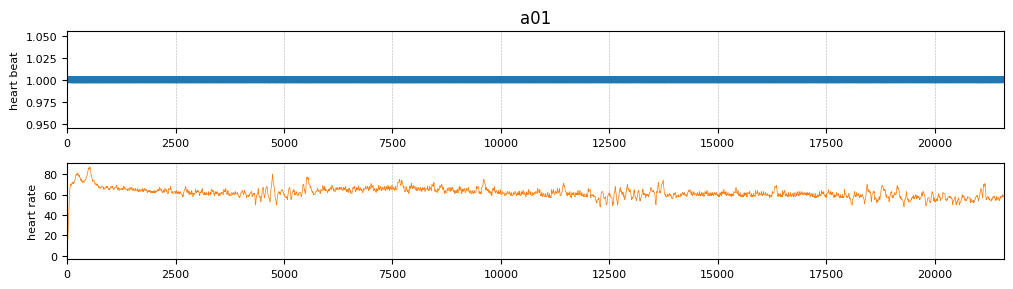

In [11]:
heart_rate = tp.rename(tp.moving_count(heart_beats, 60.0), "heart rate")

# Right now, the heart rate is computed at each heart beat.
# This resolution is great for computation, but this is an overkill for plotting.
# Let's compute the heart beat once every 20 seconds instead.
#
# TODO: Uniform resampling.
# low_resolution_heart_rate = tp.rename(heart_rate, "low res heart rate")

to_plot = [
    heart_beats,
    heart_rate,
    # low_resolution_heart_rate
]

tp.plot(
    tp.evaluate(to_plot, {ecg_node: ecg_data}),
    min_time=0,
    max_time=tp.duration.hours(6),
    indexes="a01",
)

The heart rate variability (HRV) is the standard deviation of the interval between successive heart beats and expressed in ms.

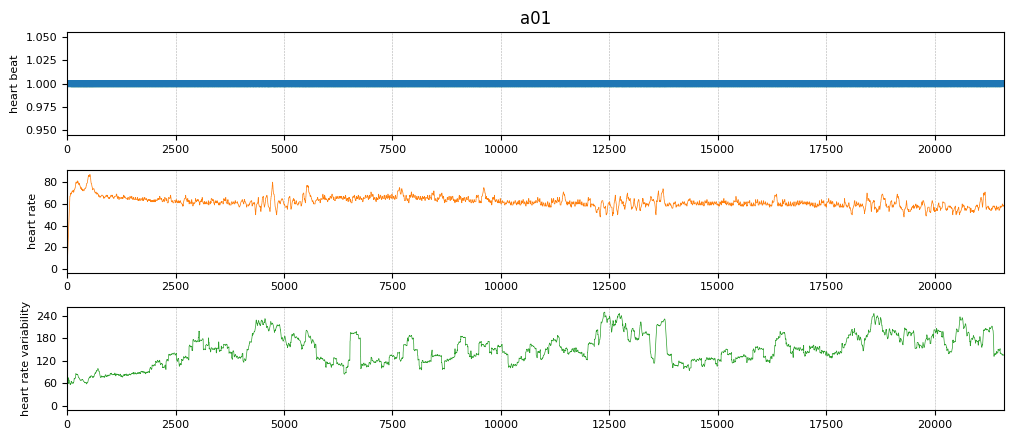

In [9]:
rr_interval = tp.since_last(heart_beats)

heart_rate_variability = tp.rename(
    tp.moving_standard_deviation(rr_interval, 240.0) * 1000.0,
    "heart rate variability",
)

to_plot = [
    heart_beats,
    heart_rate,
    heart_rate_variability,
]

tp.plot(
    tp.evaluate(to_plot, {ecg_node: ecg_data}),
    min_time=0,
    max_time=tp.duration.hours(6),
    indexes="a01",
)

Now that we have temporian programs to compute the HR and HRV, let's apply it to all ours patients and on the full data:

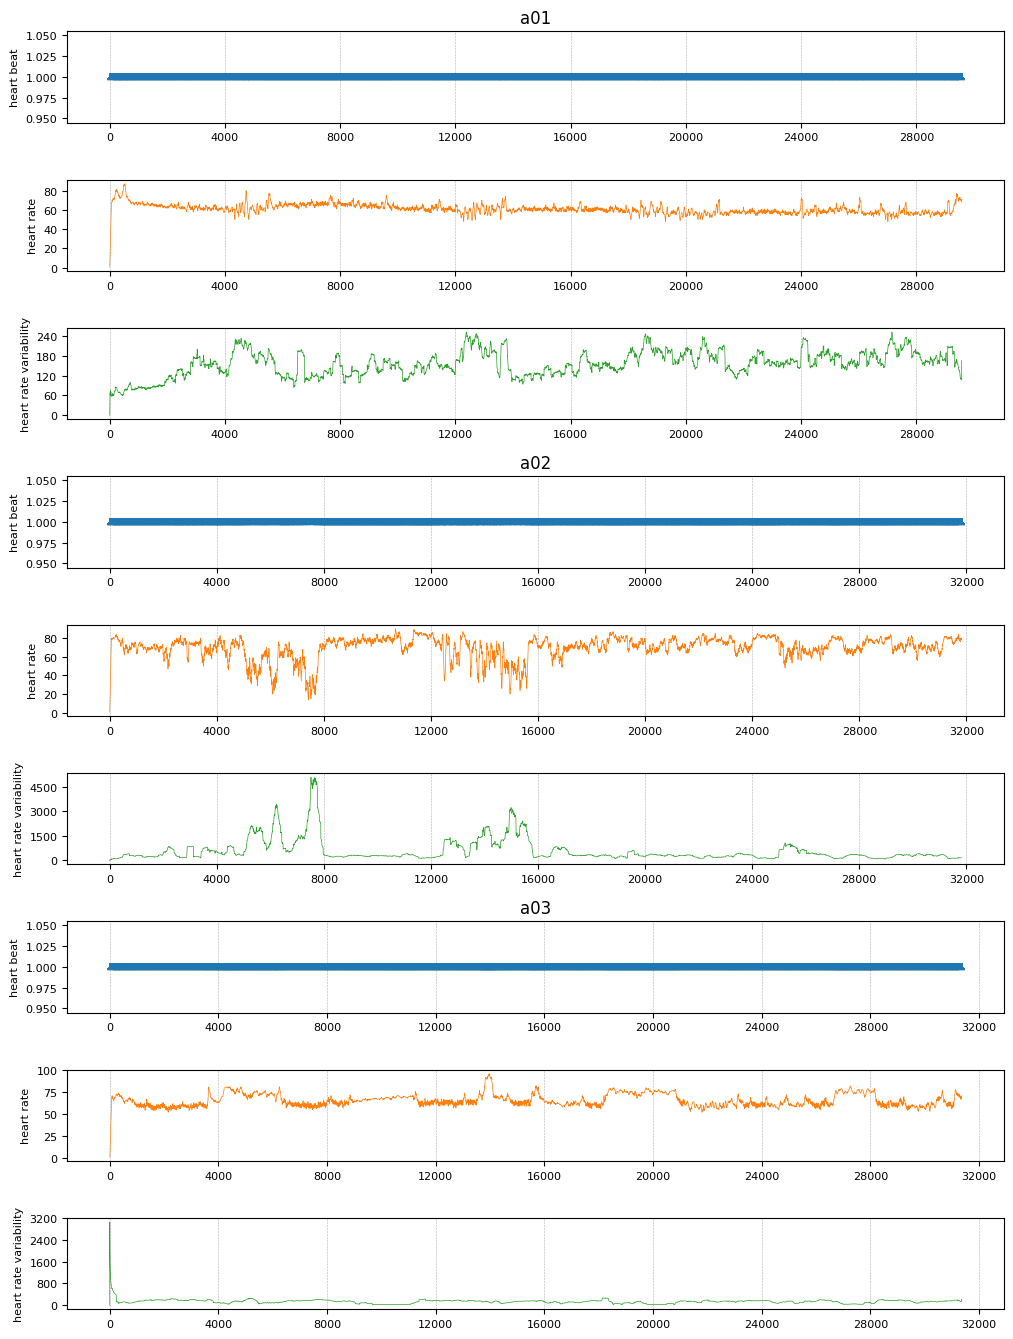

In [10]:
tp.plot(tp.evaluate(to_plot, {ecg_node: ecg_data}))

Finally, we can export our temporian programs for later re-use: